Importing Libraries

In [1]:
import os
import copy
import csv
from tqdm import tqdm
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle
from cryptography.fernet import Fernet

Splitting the data into the 3 nodes 

In [ ]:

#  Function to extract label from filename
def extract_label(filename):
    parts = filename.split("_")  # Split by underscore
    if len(parts) >= 3:
        label = parts[2].upper()  # Third part (e.g., 'N' or 'P')
        if label in ["N", "P"]:
            return label
    return None

# Define datasets

datasets = {
    "N1": {
        "root_dir": "/new_N1",
        "csv_output_path": "/image_labels_newRunN1.csv"
    },
    "N2": {
        "root_dir": "/new_N2",
        "csv_output_path": "/image_labels_newRunN2.csv"
    },
    "N3": {
        "root_dir": "/new_N3",
        "csv_output_path": "/image_labels_newRunN3.csv"
    }
}

# Generate CSVs
for name, paths in datasets.items():
    root_dir = paths["root_dir"]
    csv_output_path = paths["csv_output_path"]

    data = []
    for file_name in os.listdir(root_dir):
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            label = extract_label(file_name)
            if label:
                image_path = os.path.join(root_dir, file_name)
                data.append([image_path, label])

    with open(csv_output_path, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["image_path", "label"])
        writer.writerows(data)

    print(f"✅ CSV for {name} saved at {csv_output_path} with {len(data)} entries.")


✅ CSV for N1 saved at C:/Users/Majid Almheiri/Desktop/Special Topics/New/CSV Files/N1/image_labels_newRunN1.csv with 13332 entries.
✅ CSV for N2 saved at C:/Users/Majid Almheiri/Desktop/Special Topics/New/CSV Files/N2/image_labels_newRunN2.csv with 13334 entries.
✅ CSV for N3 saved at C:/Users/Majid Almheiri/Desktop/Special Topics/New/CSV Files/N3/image_labels_newRunN3.csv with 13336 entries.


Dataset Class

In [3]:
class XrayDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = {label: idx for idx, label in enumerate(self.data['label'].unique())}
        self.data['label'] = self.data['label'].map(self.label_map)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_path).convert('L')
        label = int(self.data.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

Model Function

In [ ]:
# Model function
def get_model(num_classes):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

    pretrained_conv = model.features[0][0]
    new_conv = nn.Conv2d(1, pretrained_conv.out_channels,
                         kernel_size=pretrained_conv.kernel_size,
                         stride=pretrained_conv.stride,
                         padding=pretrained_conv.padding,
                         bias=False)

    with torch.no_grad():
        new_conv.weight = nn.Parameter(pretrained_conv.weight.sum(dim=1, keepdim=True))

    model.features[0][0] = new_conv
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    return model

Training Function

In [5]:
def local_train(model, train_loader, val_loader, epochs, lr=5e-5):
    model = copy.deepcopy(model).to(device)
    model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

    train_accs, val_accs = [], []
    train_losses, val_losses = [] , []

    for epoch in range(epochs):
        correct = total = 0
        epoch_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accs.append(100 * correct / total)
        train_losses.append(epoch_loss / len(train_loader))

        model.eval()
        correct = total = 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accs.append(100 * correct / total)
        val_losses.append(val_loss / len(val_loader))
        scheduler.step(val_accs[-1])
        model.train()

    return model.state_dict(), train_accs, val_accs, train_losses, val_losses

Aggregator  

In [6]:
def average_weights(weights_list):
    avg_weights = copy.deepcopy(weights_list[0])
    for key in avg_weights.keys():
        for i in range(1, len(weights_list)):
            avg_weights[key] += weights_list[i][key]
        avg_weights[key] = torch.div(avg_weights[key], len(weights_list))
    return avg_weights

Evaluation function

In [7]:
def evaluate(model, dataloader):
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    return accuracy, correct, total, all_preds, all_labels

Data Pre-Processing for every client 

In [ ]:
client_dirs = {
    'N1': {'csv': "/image_labels_newRunN1.csv", 'root': "/new_N1"},
    'N2': {'csv': "/image_labels_newRunN2.csv", 'root': "/new_N2"},
    'N3': {'csv': "/image_labels_newRunN3.csv", 'root': "/new_N3"}
}

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(512, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

clients = {}
for client_name, client_dir in client_dirs.items():
    dataset = XrayDataset(csv_file=client_dir['csv'], root_dir=client_dir['root'], transform=transform)
    ds_size = len(dataset)
    train_size = int(0.8 * ds_size)
    val_size = int(0.1 * ds_size)
    test_size = ds_size - train_size - val_size

    generator = torch.Generator().manual_seed(42)
    train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size], generator=generator)

    train_loader = DataLoader(train_data, batch_size=16, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_data, batch_size=16, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=16, shuffle=False, pin_memory=True)

    clients[client_name] = {'train_loader': train_loader, 'val_loader': val_loader, 'test_loader': test_loader}

Encryption / Decryption Functions

In [9]:
# Generate encryption key and cipher
encryption_key = Fernet.generate_key()
cipher = Fernet(encryption_key)

def encrypt_model_weights(weights):
    byte_data = pickle.dumps(weights)
    encrypted_data = cipher.encrypt(byte_data)
    return encrypted_data

def decrypt_model_weights(encrypted_data):
    decrypted_data = cipher.decrypt(encrypted_data)
    weights = pickle.loads(decrypted_data)
    return weights

Training 

In [ ]:
# Safe GPU autotuning
cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

model = get_model(num_classes=2).to(device)

num_rounds = 10
local_epochs = 2
client_history = {name: {'train': [], 'val': [], 'train_loss': [], 'val_loss': []} for name in clients}

global_accuracies = []
global_losses = []

for rnd in tqdm(range(num_rounds), desc="Federated Rounds"):
    print(f"\n🔹 Federated Round {rnd + 1}")
    encrypted_local_weights = []
    for cname, loaders in clients.items():
        print(f" - Training on {cname}")
        
        # Local training
        lw, train_accs, val_accs, train_losses, val_losses = local_train(
            model, loaders['train_loader'], loaders['val_loader'], epochs=local_epochs)
        
        # Encrypt weights
        encrypted_weights = encrypt_model_weights(lw)
        encrypted_local_weights.append(encrypted_weights)

        # Store history
        client_history[cname]['train'].extend(train_accs)
        client_history[cname]['val'].extend(val_accs)
        client_history[cname]['train_loss'].extend(train_losses)
        client_history[cname]['val_loss'].extend(val_losses)

        # Print last epoch training accuracy
        print(f" Final training accuracy: {train_accs[-1]:.2f}%")

    # Decrypt all weights before averaging
    decrypted_local_weights = [decrypt_model_weights(e_w) for e_w in encrypted_local_weights]
    global_w = average_weights(decrypted_local_weights)

    model.load_state_dict(global_w)
    torch.save(global_w, f'global_model_round{rnd + 1}.pth')
    print(f"Saved global model round {rnd + 1}")


Using cuda


Federated Rounds:   0%|          | 0/10 [00:00<?, ?it/s]


🔹 Federated Round 1
 - Training on N1


c:\XboxGames\Anaconda\envs\torch-env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


   ↪️ Final training accuracy: 76.56%
 - Training on N2
   ↪️ Final training accuracy: 76.80%
 - Training on N3
   ↪️ Final training accuracy: 76.05%


Federated Rounds:  10%|█         | 1/10 [14:03<2:06:35, 843.94s/it]

✅ Saved global model round 1

🔹 Federated Round 2
 - Training on N1
   ↪️ Final training accuracy: 79.66%
 - Training on N2
   ↪️ Final training accuracy: 79.47%
 - Training on N3
   ↪️ Final training accuracy: 79.27%


Federated Rounds:  20%|██        | 2/10 [25:43<1:41:12, 759.03s/it]

✅ Saved global model round 2

🔹 Federated Round 3
 - Training on N1
   ↪️ Final training accuracy: 81.72%
 - Training on N2
   ↪️ Final training accuracy: 81.02%
 - Training on N3
   ↪️ Final training accuracy: 80.77%


Federated Rounds:  30%|███       | 3/10 [37:22<1:25:20, 731.47s/it]

✅ Saved global model round 3

🔹 Federated Round 4
 - Training on N1
   ↪️ Final training accuracy: 81.82%
 - Training on N2
   ↪️ Final training accuracy: 82.15%
 - Training on N3
   ↪️ Final training accuracy: 81.45%


Federated Rounds:  40%|████      | 4/10 [48:59<1:11:48, 718.05s/it]

✅ Saved global model round 4

🔹 Federated Round 5
 - Training on N1
   ↪️ Final training accuracy: 82.74%
 - Training on N2
   ↪️ Final training accuracy: 82.70%
 - Training on N3
   ↪️ Final training accuracy: 82.86%


Federated Rounds:  50%|█████     | 5/10 [1:00:38<59:14, 710.99s/it]

✅ Saved global model round 5

🔹 Federated Round 6
 - Training on N1
   ↪️ Final training accuracy: 83.46%
 - Training on N2
   ↪️ Final training accuracy: 83.40%
 - Training on N3
   ↪️ Final training accuracy: 83.16%


Federated Rounds:  60%|██████    | 6/10 [1:12:17<47:07, 706.94s/it]

✅ Saved global model round 6

🔹 Federated Round 7
 - Training on N1
   ↪️ Final training accuracy: 84.17%
 - Training on N2
   ↪️ Final training accuracy: 83.73%
 - Training on N3
   ↪️ Final training accuracy: 83.97%


Federated Rounds:  70%|███████   | 7/10 [1:23:55<35:12, 704.24s/it]

✅ Saved global model round 7

🔹 Federated Round 8
 - Training on N1
   ↪️ Final training accuracy: 84.46%
 - Training on N2
   ↪️ Final training accuracy: 84.72%
 - Training on N3
   ↪️ Final training accuracy: 84.17%


Federated Rounds:  80%|████████  | 8/10 [1:35:34<23:24, 702.32s/it]

✅ Saved global model round 8

🔹 Federated Round 9
 - Training on N1
   ↪️ Final training accuracy: 85.29%
 - Training on N2
   ↪️ Final training accuracy: 84.88%
 - Training on N3
   ↪️ Final training accuracy: 84.59%


Federated Rounds:  90%|█████████ | 9/10 [1:47:11<11:40, 700.71s/it]

✅ Saved global model round 9

🔹 Federated Round 10
 - Training on N1
   ↪️ Final training accuracy: 85.67%
 - Training on N2
   ↪️ Final training accuracy: 85.83%
 - Training on N3
   ↪️ Final training accuracy: 85.64%


Federated Rounds: 100%|██████████| 10/10 [1:58:49<00:00, 713.00s/it]

✅ Saved global model round 10


Testing

In [11]:
# Final Evaluation
print("\n🌟 Final Global Model Test Accuracies:")
tot_corr = tot = 0
global_test_accuracies = []
confusion_data = {}


for cname, ld in clients.items():
    acc, corr, cnt, preds, labels = evaluate(model, ld['test_loader'])
    tot_corr += corr
    tot += cnt
    global_test_accuracies.append((cname, acc))
    confusion_data[cname] = (labels, preds)
    print(f" - {cname}: {acc:.2f}%")

overall_acc = 100 * tot_corr / tot
print(f"\n🌟 Overall Global Test Accuracy: {overall_acc:.2f}%")


🌟 Final Global Model Test Accuracies:
 - N1: 83.58%
 - N2: 84.48%
 - N3: 85.47%

🌟 Overall Global Test Accuracy: 84.51%


Plots

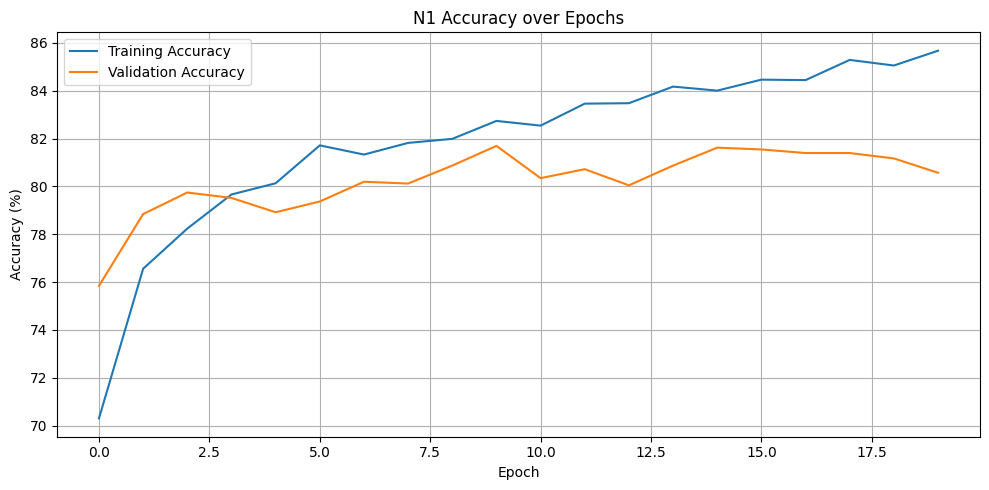

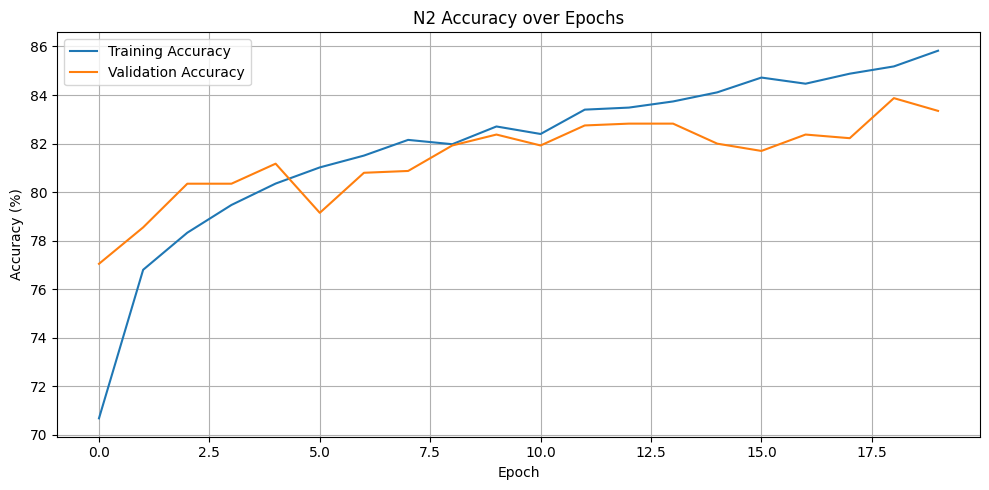

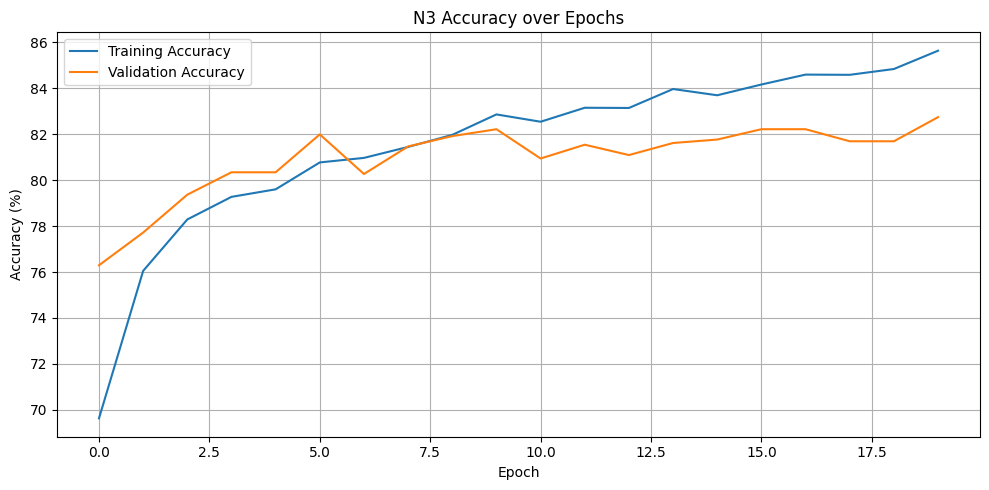

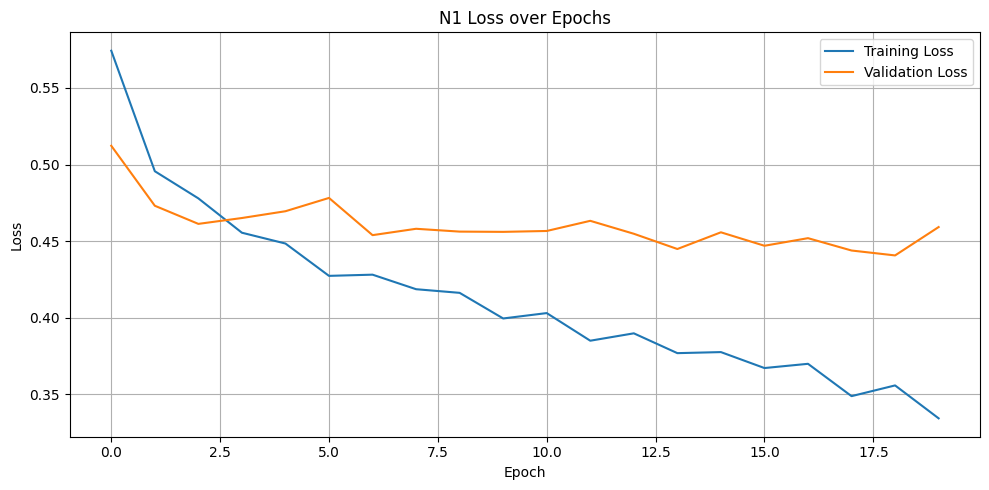

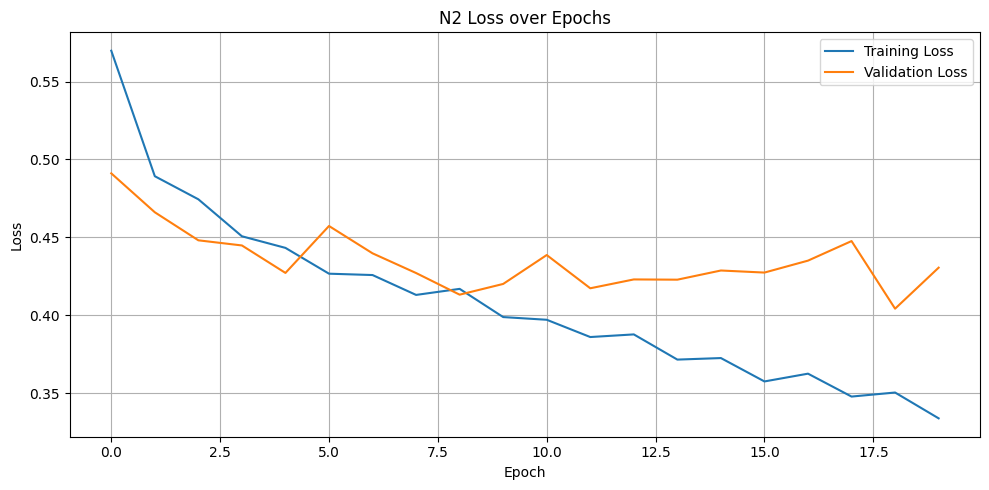

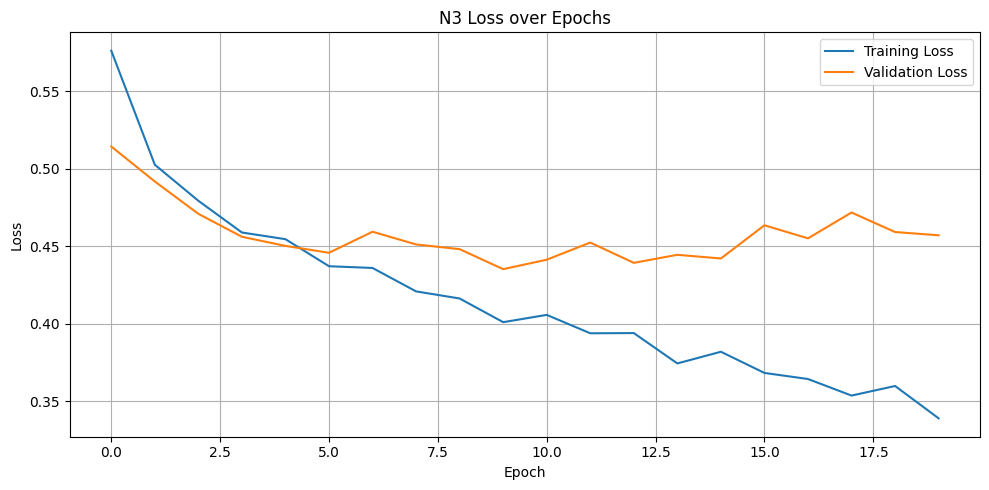

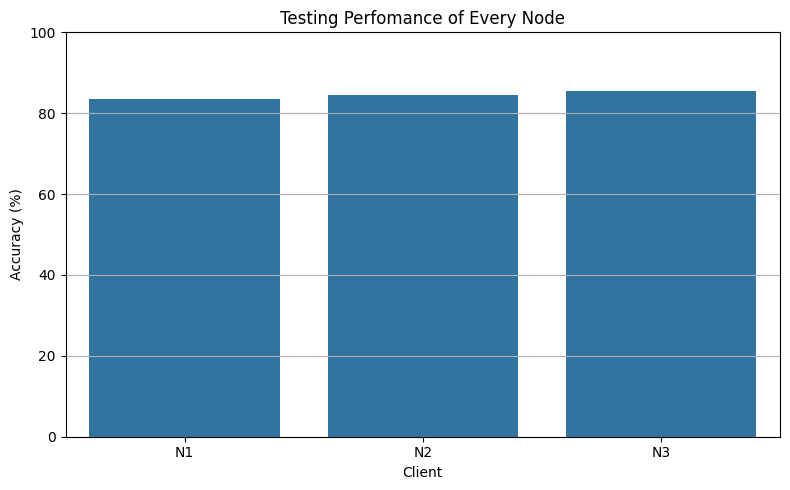

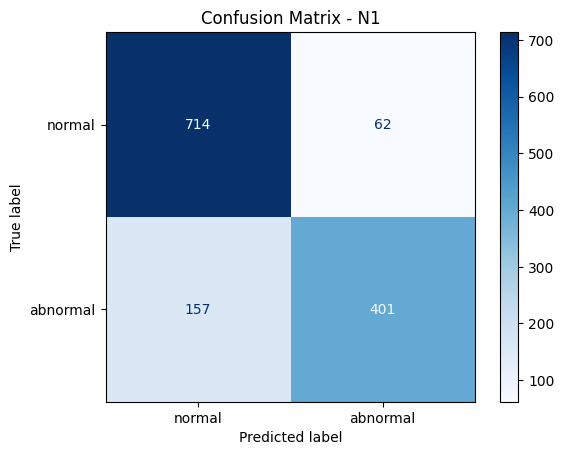

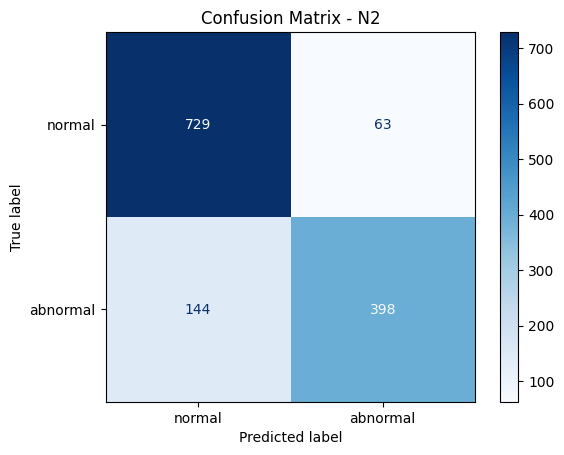

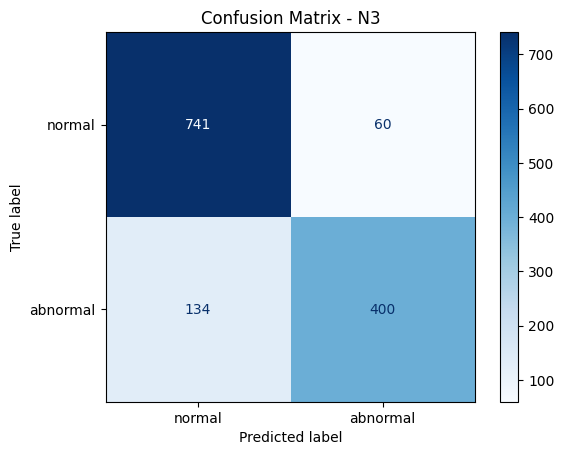

In [12]:
# Accuracy plots
for client, history in client_history.items():
    plt.figure(figsize=(10, 5))
    plt.plot(history['train'], label='Training Accuracy')
    plt.plot(history['val'], label='Validation Accuracy')
    plt.title(f'{client} Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Loss plots
for client, history in client_history.items():
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{client} Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Bar chart for testing accuracy
names, accs = zip(*global_test_accuracies)
plt.figure(figsize=(8, 5))
sns.barplot(x=list(names), y=list(accs))
plt.title('Testing Perfomance of Every Node')
plt.ylabel('Accuracy (%)')
plt.xlabel('Client')
plt.ylim(0, 100)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Confusion matrices
for cname, (labels, preds) in confusion_data.items():
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'abnormal'])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {cname}')
    plt.show()

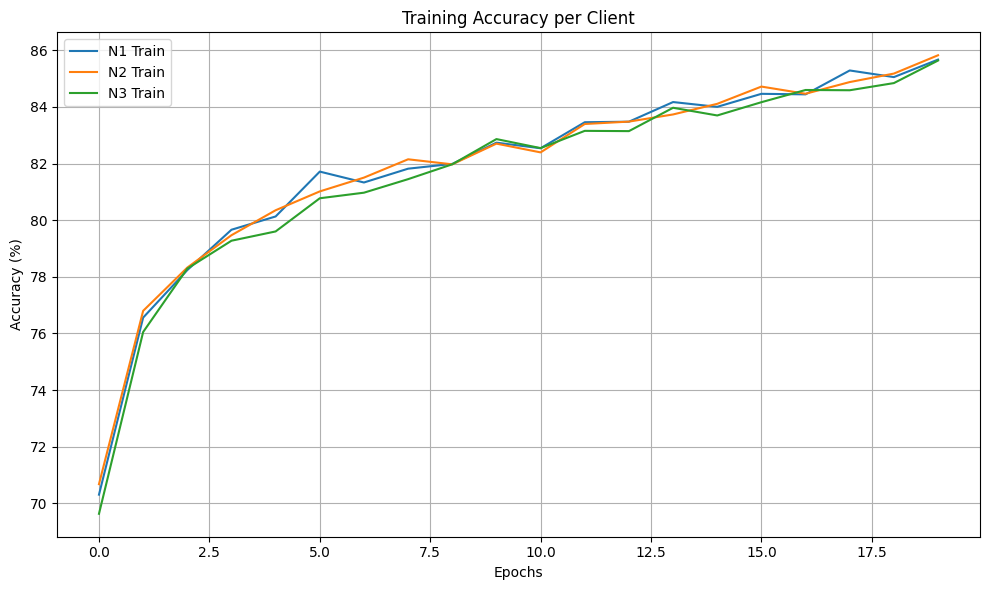

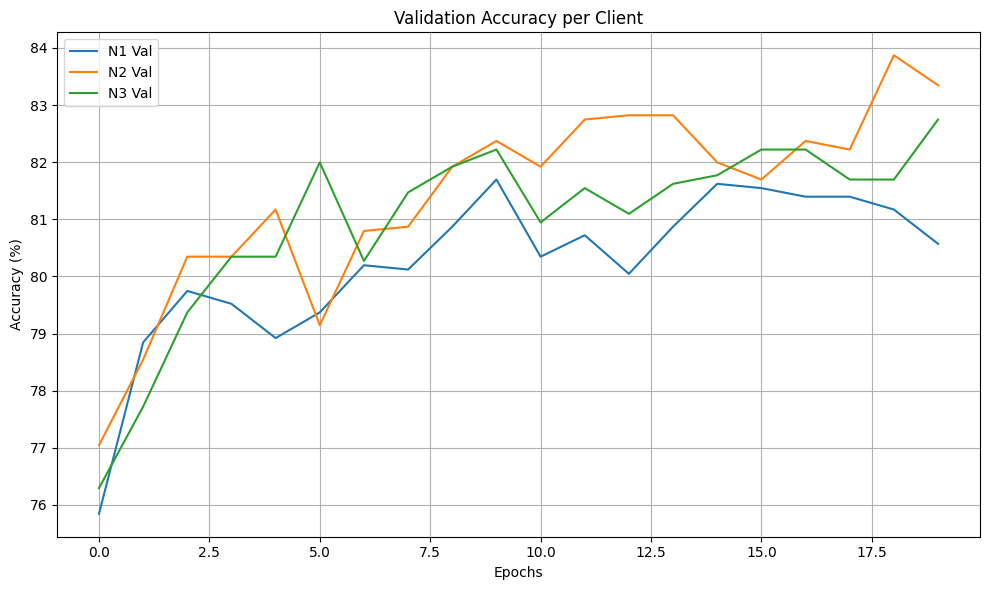

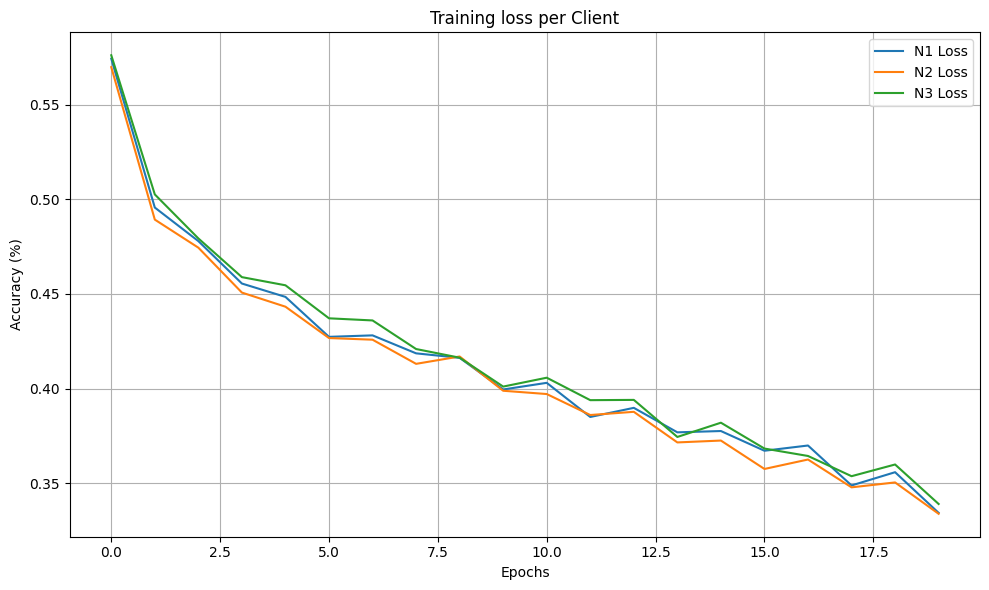

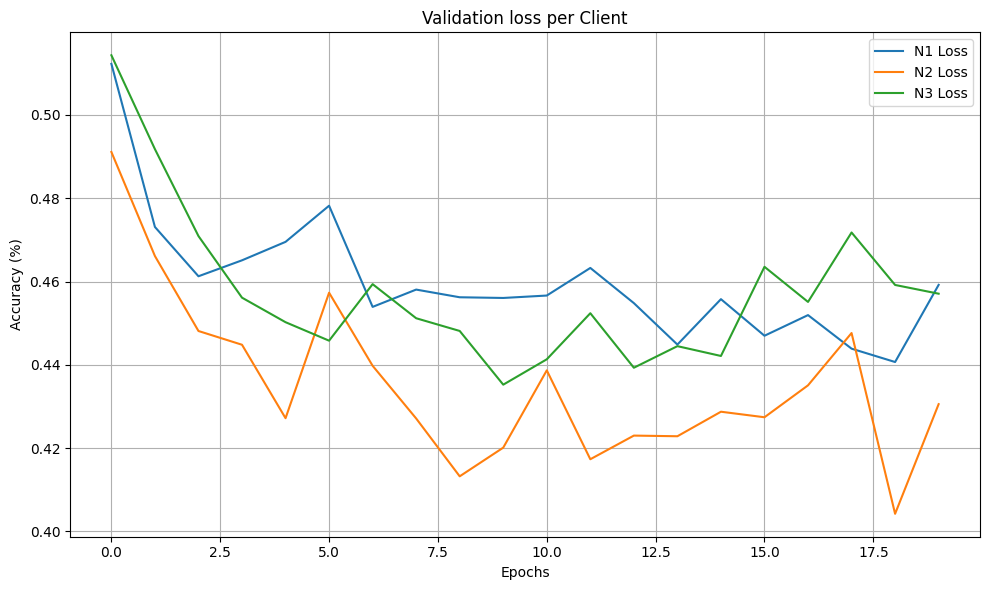

In [ ]:
# Combined Training Accuracy
plt.figure(figsize=(10, 6))
for client, history in client_history.items():
    plt.plot(history['train'], label=f"{client} Train")
plt.title("Training Accuracy per Client")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Validation
plt.figure(figsize=(10, 6))
for client, history in client_history.items():
    plt.plot(history['val'], label=f"{client} Val")
plt.title("Validation Accuracy per Client")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Combined Loss Training
plt.figure(figsize=(10, 6))
for client, history in client_history.items():
    plt.plot(history['train_loss'], label=f"{client} Loss")
plt.title("Training loss per Client")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Combined Loss Validation
plt.figure(figsize=(10, 6))
for client, history in client_history.items():
    plt.plot(history['val_loss'], label=f"{client} Loss")
plt.title("Validation loss per Client")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
